## Benchmarking


I'm using this code to benchmark underlying function and my code generation tactics

will use a 2B1T + FWTD model and relise it at 20 m/s & 5 deg aoa

In [1]:
import pandas as pd
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

In [2]:

%%time
flutdf = pd.DataFrame()
b_modes = 3
t_modes = 3

model_names = {0:'Free-IWT',1:'Free-IWT,IWB',2:'Free-IWT,IWB,Rot',3:'Free-IWT,IWB,Rot,Stall',
               4:'Free-IWT,IWB,Rot,Stall,Drag',5:'Free-IWT,Rot,Stall,Drag',
               6:'Free-IWT,IWB,Rot,Stall,Drag,Lin0',7:'Free-IWT,Rot,Stall,Drag,Lin0'}


ls = []
for i in [0]:
#for i in range(8):
    for j in ["WT","JEC","HALE"]:
        dat = pd.read_pickle(f'fp_data_{b_modes}B{t_modes}T-M{i}_{j}.pkl')
        dat['Model'] = i
        dat['Config'] = j
        ls.append(dat)
    
flutdf = pd.concat(ls, ignore_index=True, sort=False)

flutdf = flutdf.reset_index(drop=True)
flutdf['Coast Angle [Deg]'] = (np.rad2deg([i[-1] for i in flutdf['q']]))
flutdf['FWT Mass [%]'] = pd.Categorical(flutdf['delta_m']*100)
flutdf['Flare Angle [Deg]'] = pd.Categorical(np.rad2deg(flutdf['Lambda']))
flutdf['AoA [Deg]'] = pd.Categorical(np.rad2deg(flutdf['alpha_r']))
flutdf['Model'] = pd.Categorical(flutdf['Model'])
flutdf['Config'] = pd.Categorical(flutdf['Config'])
flutdf['c_dmax'] = pd.Categorical(flutdf['c_dmax'])
flutdf['Locked'] = pd.Categorical(flutdf['k_fwt']>0)
flutdf['Mode'] =0
flutdf.head(5)

CPU times: user 32.3 ms, sys: 5.22 ms, total: 37.5 ms
Wall time: 38.1 ms


,V,alpha_r,delta_m,c_dmax,k_fwt,Lambda,Lift,q,Model,Config,Coast Angle [Deg],FWT Mass [%],Flare Angle [Deg],AoA [Deg],Locked,Mode
0,10.0,-0.087266,0.5,0.0,0.0,0.174533,-4.933227,"[-2.274573482047157e-05, -0.1069278009558743, ...",0,WT,68.124636,50.0,10.0,-5.0,False,0
1,10.0,-0.069813,0.5,0.0,0.0,0.174533,-3.837002,"[-2.164950965599655e-05, -0.10207637034932845,...",0,WT,67.532794,50.0,10.0,-4.0,False,0
2,10.0,-0.052360,0.5,0.0,0.0,0.174533,-2.734456,"[-2.0546963576010025e-05, -0.09717662928616888...",0,WT,66.882963,50.0,10.0,-3.0,False,0
3,10.0,-0.034907,0.5,0.0,0.0,0.174533,-1.626237,"[-1.9438744276172773e-05, -0.09222542435993379...",0,WT,66.168752,50.0,10.0,-2.0,False,0
4,10.0,-0.017453,0.5,0.0,0.0,0.174533,-0.512941,"[-1.8325448542666803e-05, -0.08721911412581583...",0,WT,65.382934,50.0,10.0,-1.0,False,0


In [3]:
flutdf['Locked'].unique()

[False, True]
Categories (2, object): [False, True]

### Load all test data into a singe dataframe

In [4]:
def GetReducedDataSet(flutdf,model_num,Config = ["JEC"],Flare=25,FWT_mass = [100],AoA=0,c_dmax = 0,Vmin = 1,Vmax = 140,Locked = False):
    data = flutdf.copy()
    data = data[cpo.SeriesFilter(data['Model'],model_num)]
    data = data[cpo.SeriesFilter(data['Flare Angle [Deg]'],Flare)]
    data = data[cpo.SeriesFilter(data['FWT Mass [%]'],FWT_mass)]
    data = data[cpo.SeriesFilter(data['AoA [Deg]'],AoA)]
    data = data[cpo.SeriesFilter(data['Config'],Config)]
    data = data[data['V']<=Vmax]
    data = data[data['V']>=Vmin]
    
    data = data[cpo.SeriesFilter(data['c_dmax'],c_dmax)]
    data = data[cpo.SeriesFilter(data['Locked'],Locked)]
    return data

In [5]:
d = GetReducedDataSet(flutdf,[5],Config = ["WT"])
d.head(5)

,V,alpha_r,delta_m,c_dmax,k_fwt,Lambda,Lift,q,Model,Config,Coast Angle [Deg],FWT Mass [%],Flare Angle [Deg],AoA [Deg],Locked,Mode


## Compare Non-Linear Models

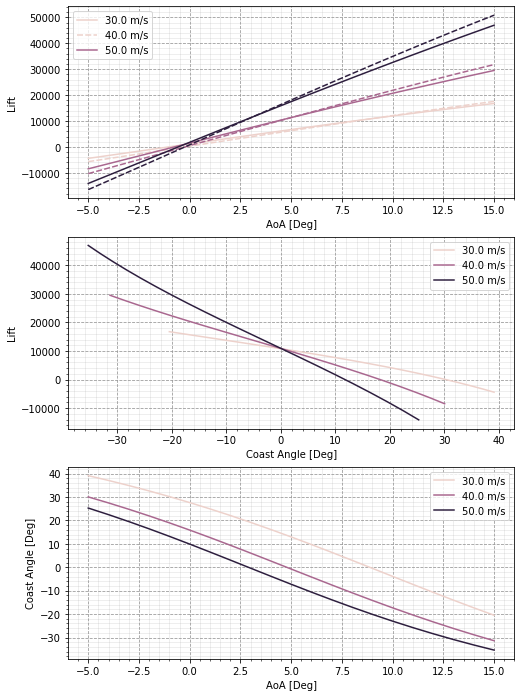

In [7]:
fig, axes = plt.subplots(3,1,figsize=(8,12))    

Tests = [0]
hue = 'Model'
data = GetReducedDataSet(flutdf,Tests,Config = ["JEC"],c_dmax = 0,
                         Flare = 17.5,AoA = None,Locked = None)

sns.lineplot(data = data,x='AoA [Deg]',y='Lift',hue = 'V',style='Locked',ax=axes[0])
sns.lineplot(data = data[data['Locked']==False],x='Coast Angle [Deg]',y='Lift',hue = 'V',ax=axes[1])
sns.lineplot(data = data[data['Locked']==False],x='AoA [Deg]',y='Coast Angle [Deg]',hue = 'V',ax=axes[2])



#cpo.PlotLines(data,x = 'AoA [Deg]',Modes = [0],hue = hue,y = 'Lift',ax = axes[0])
#cpo.PlotLines(data,x = 'V',Modes = flutdf['Mode'].cat.categories,hue = hue,y = 'Damping [%]',ax = axes[1])
#cpo.CoastDeltaPlot(data,hue, axes[2],Delta = False)
for i in [0,1,2]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    #axes[i].set(xlim=(0,40))
    

#axes[0].set_ylabel('Frequency [Hz]')
#axes[1].set_ylabel('Damping %')

#axes[0].set(ylim=(0.5,3))
#axes[0].set(ylim=(0,3))
#axes[1].set(ylim=(-20,50))    
#axes[2].set(ylim=(-100,100))  


#PlotModes(data,'Test',axes[:])
for i in [0,1,2]:
    axes[i].legend([f'{v} m/s' for v in data['V'].unique()])
#axes[1].legend(data['V'].unique())
#axes[2].legend(data['V'].unique())
#axes[1].legend(data[hue].unique())
#axes[1].legend(flutdf['AoA [Deg]'].cat.categories)
#fig.show()
#PlotModes(1,axes[:,0],Flare = 25)

## Parameter Sweeps

[1.]


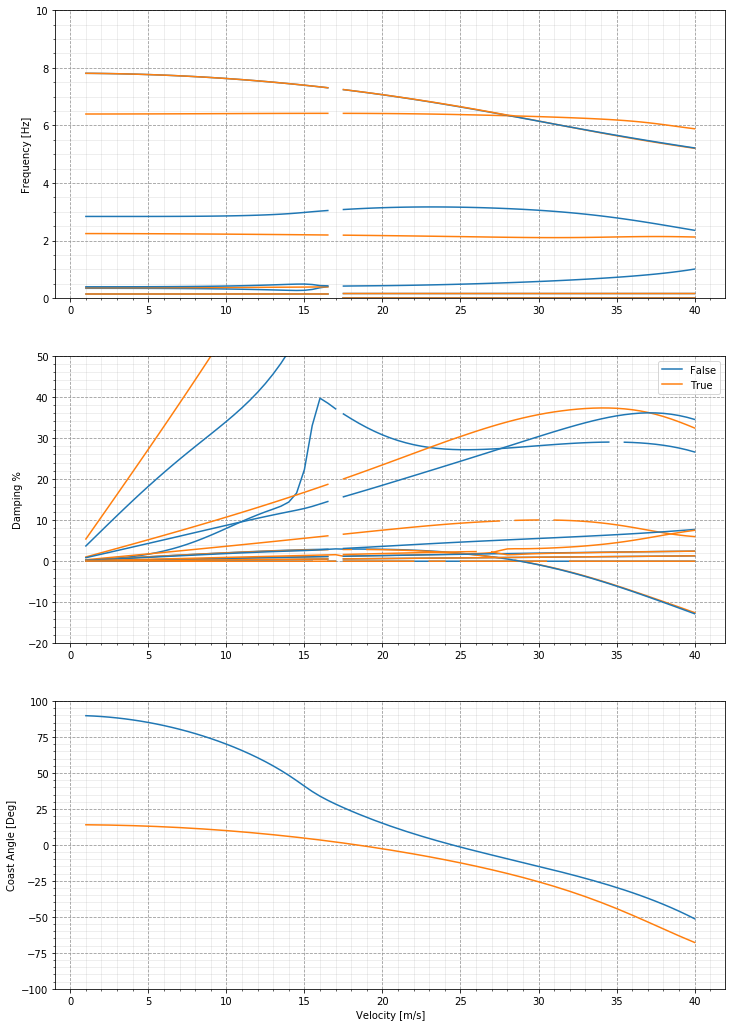

In [81]:
fig, axes = plt.subplots(3,1,figsize=(12,18))    

Tests = [5]
#hue = 'AoA [Deg]'
#hue = 'Flare Angle [Deg]'
#hue = 'FWT Mass [%]'
#hue = 'c_dmax'
hue = 'Locked'

data = GetReducedDataSet(flutdf,Tests,
                         Config = ["HALE"],
                         ratio_FWT=20,
                         FWT_mass = None if hue == 'FWT Mass [%]' else [100],
                         c_dmax = None if hue == 'c_dmax' else [1],
                         Flare = None if hue == 'Flare Angle [Deg]' else [17.5],
                         AoA = None if hue == 'AoA [Deg]' else [5],
                         Modes=None,
                         Stable=None,
                         Locked =None if hue == 'Locked' else [False])

cpo.PlotLines(data,x = 'V',Modes = flutdf['Mode'].cat.categories,hue = hue,y = 'Frequency',ax = axes[0])
cpo.PlotLines(data,x = 'V',Modes = flutdf['Mode'].cat.categories,hue = hue,y = 'Damping [%]',ax = axes[1])
cpo.CoastDeltaPlot(data,hue, axes[2],Delta = False)
print(np.unique(data['c_dmax']))
for i in [0,1,2]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    #axes[i].set(xlim=(0,40))
    

axes[0].set_ylabel('Frequency [Hz]')
axes[1].set_ylabel('Damping %')

#axes[0].set(ylim=(0.5,3))
axes[0].set(ylim=(0,10))
axes[1].set(ylim=(-20,50))    
axes[2].set(ylim=(-100,100))  


#PlotModes(data,'Test',axes[:])
#axes[1].legend([model_names[i] for i in Tests])
axes[1].legend(data[hue].unique())
#axes[1].legend(flutdf['AoA [Deg]'].cat.categories)
#fig.show()
#PlotModes(1,axes[:,0],Flare = 25)